Use Web demo here: https://console.dialogflow.com/api-client/demo/embedded/webeng-chatbot

In [1]:
%%javascript

window.scroll_flag = true
window.scroll_exit = false
window.scroll_delay = 100

$(".output_scroll").each(function() {
    $(this)[0].scrollTop = $(this)[0].scrollHeight;
    $(this).height(800);
});

function callScrollToBottom() {
    setTimeout(scrollToBottom, window.scroll_delay);
}

function scrollToBottom() {
    if (window.scroll_exit) {
        return;
    }
    if (!window.scroll_flag) {
        callScrollToBottom();
        return;
    };

    $(".output_scroll").each(function() {
        if (!$(this).attr('scroll_checkbox')){
            window.scroll_flag = true;
            $(this).attr('scroll_checkbox',true);
            var div = document.createElement('div');
            var checkbox = document.createElement('input');
            checkbox.type = "checkbox";
            checkbox.onclick = function(){window.scroll_flag = checkbox.checked}
            checkbox.checked = "checked"
            div.append("Auto-Scroll-To-Bottom: ");
            div.append(checkbox);
            $(this).parent().before(div);
        }

        $(this)[0].scrollTop = $(this)[0].scrollHeight;
        $(this).height(800);
    });
    callScrollToBottom();
}
scrollToBottom();

<IPython.core.display.Javascript object>

In [2]:
%matplotlib inline

from flask import Flask
from flask import request, jsonify

from datetime import datetime
import pickle, copy, random

from mashup import *
from ont2nl import *
from ont2confirm import *
import matplotlib.pyplot as plt
import networkx as nx

app = Flask(__name__)

In [3]:
mashups = []
graph_mashups = []
cursor = None
paused = False

# Count of added commands from last current mashup check
feedback_given = 0
last_length = 0

# Undo check
undo_used = False

In [4]:
@app.route('/', methods=['POST'])
def main():
    global mashups
    global graph_mashups
    global cursor
    global paused
    global feedback_given
    global last_length
    global undo_used

    data = request.get_json()
    ret = {}

    # check user intent
    intent = data['queryResult']['intent']['displayName']
    
    if intent == 'new_mashup':
        if paused:
            ret = {
                "fulfillmentText": "It seems you haven't finished making a mashup, please resume it."
            }
            outputContexts = data['queryResult']['outputContexts']
            
            # Reset contexts
            for context in outputContexts:
                context['lifespanCount'] = 0
        
            ret['outputContexts'] = outputContexts
        
        now = int(datetime.now().timestamp())
        print('[INFO] New mashup session initiated at ' + str(now))

        mashups.append([])
        cursor = mashups[-1]
        confirm_init()
        feedback_given = 0
        last_length = 0
        undo_used = False
    
    if intent == 'add_command':
        now = int(datetime.now().timestamp())
        print('[INFO] Command added at ' + str(now))

        cursor.append(data['queryResult']['parameters'])
        try:
            m = Mashup()
            m.init_list(copy.deepcopy(mashups[-1]))
            feedback_given += m.graph.number_of_nodes() - last_length
            last_length = m.graph.number_of_nodes()

            ret['fulfillmentText'] = speak_add_command(m, False if feedback_given > 4 else True)
            
            plt.figure(figsize=(8,8))
            nx.draw_networkx(m.graph)
            plt.show()

            if feedback_given > 4:
                now = int(datetime.now().timestamp())
                print('[INFO] Feedback suggested at ' + str(now))

                ret["outputContexts"] = [
                    {"name": "{}/contexts/add_command-followup".format(data['session']),
                     "lifespanCount": 2}
                ]
                
                ret["fulfillmentText"] += "Great. Before moving on to the next step, would you like to check the current progress of your mashup?"

                feedback_given = 0

        except Exception as e:
            print('[Error] Failed to instantiate the mashup - ' + str(e))
            cursor.pop()
            ret = {
                "fulfillmentText": "Oops, I failed to process your input. Could you rephrase it?",
            }

            return jsonify(ret)

    if intent == 'undo_command':
        now = int(datetime.now().timestamp())
        print('[INFO] Command undone at ' + str(now))

        feedback_given += 1
        last_length -= 1

        try:
            cursor.pop()
        except IndexError as e:
            print('[Error] Failed to pop a command - ' + str(e))
            ret['fulfillmentText'] = 'Sorry, you cannot undo when you did not add any commands.'

            return jsonify(ret)

        if not undo_used:
            undo_used = True
            ret['fulfillmentText'] = 'Sure, the last command has been undone. Please tell me commands you want to add.'
        else:
            ret_str = [
                'Removing the last action.',
                'Undoing the last action.'
            ]
            ret['fulfillmentText'] = random.choice(ret_str)
        
        m = Mashup()
        m.init_list(copy.deepcopy(mashups[-1]))
        plt.figure(figsize=(8,8))
        nx.draw_networkx(m.graph)
        plt.show()

    if intent == 'pause_add_command':
        now = int(datetime.now().timestamp())
        print('[INFO] Paused at ' + str(now) + ' - ' + str(cursor))
        outputContexts = data['queryResult']['outputContexts']
        for context in outputContexts:
            context['lifespanCount'] = 0
        
        ret['outputContexts'] = outputContexts
        paused = True
    
    if intent == 'resume_add_command':
        now = int(datetime.now().timestamp())
        print('[INFO] Resumed at ' + str(now) + ' - ' + str(cursor))
        paused = False

    if intent == 'finish_add_command':
        # Check if the mashup is empty
        if len(cursor) == 0:
            ret = {
                "fulfillmentText": "Umm... Nothing has been added.",
                "payload": {
                    'google': {'expectUserResponse': False}
                }
            }

            return jsonify(ret)
        
        if feedback_given > 2:
            now = int(datetime.now().timestamp())
            print('[INFO] Feedback suggested at ' + str(now))
            
            outputContexts = data['queryResult']['outputContexts']
            for context in outputContexts:
                if 'finish_add_command-followup' not in context['name']:
                    context['lifespanCount'] = 0
            
            ret['outputContexts'] = outputContexts
            ret["fulfillmentText"] = "Okay, it's almost ready. Before I deploy your mashup, do you want to check it out?"

            return jsonify(ret)
        else:
            ret['payload'] = {
                'google': {'expectUserResponse': False}
            }

        now = int(datetime.now().timestamp())
        f = open('dump/multi-' + str(now) + '.bin', 'wb+')
        pickle.dump(cursor, f)

        print('[INFO] New mashup created at ' + str(now) + ' - ' + str(cursor))

        f.close()
        cursor = None

        # Build a mashup from dump file
        try:
            m = Mashup()
            m.init_list(copy.deepcopy(mashups[-1]))

            plt.figure(figsize=(8,8))
            nx.draw_networkx(m.graph)
            plt.savefig('dump/multi-' + str(now) + '.png')
            plt.show()
            plt.close('all')
                    
            # If not redundant
            graph_mashups.append(m)

        except Exception as e:
            print('[Error] Failed to instantiate the mashup - ' + str(e))
            ret = {
                "fulfillmentText": "Sorry, something strange has occurred while processing your input.",
                "payload": {
                    'google': {'expectUserResponse': False}
                }
            }

            return jsonify(ret)
        
        # Resetting contexts
        outputContexts = data['queryResult']['outputContexts']
        for context in outputContexts:
            context['lifespanCount'] = 0
        
        ret['outputContexts'] = outputContexts

    if intent == 'finish_add_command - no' or intent == 'finish_add_command - yes - yes':
        now = int(datetime.now().timestamp())
        f = open('dump/multi-' + str(now) + '.bin', 'wb+')
        pickle.dump(cursor, f)

        print('[INFO] New mashup created at ' + str(now) + ' - ' + str(cursor))

        f.close()
        cursor = None

        # Build a mashup from dump file
        try:
            m = Mashup()
            m.init_list(copy.deepcopy(mashups[-1]))

            plt.figure(figsize=(8, 8))
            nx.draw_networkx(m.graph)
            plt.savefig('dump/multi-' + str(now) + '.png')
            plt.show()
            plt.close('all')
                    
            graph_mashups.append(m)

        except Exception as e:
            print('[Error] Failed to instantiate the mashup - ' + str(e))
            ret = {
                "fulfillmentText": "Sorry, something strange has occurred while processing your input.",
                "payload": {
                    'google': {'expectUserResponse': False}
                }
            }

            return jsonify(ret)
        
        # Resetting contexts
        outputContexts = data['queryResult']['outputContexts']
        for context in outputContexts:
            context['lifespanCount'] = 0
        
        ret['outputContexts'] = outputContexts

    if intent == 'finish_add_command - yes':
        now = int(datetime.now().timestamp())
        print('[INFO] Final feedback is provided at ' + str(now))
        f = open('dump/multi-' + str(now) + '-cur' + '.bin', 'wb+')
        pickle.dump(cursor, f)
        f.close()

        # Build a mashup from dump file
        try:
            m = Mashup()
            m.init_list(copy.deepcopy(cursor))

            ret = {
                "outputContexts": [
                    {"name": "{}/contexts/finish_add_command-yes-followup".format(data['session']),
                     "lifespanCount": 2}
                ],
            }

            fulfillmentText = speak_mashup(m) + 'Do you want to deploy your mashup?</speak>'
            ret['fulfillmentText'] = fulfillmentText
            feedback_given = 0 
        except:
            print('[Error] Failed to instantiate the mashup - ' + str(e))
            ret = {
                "fulfillmentText": "Sorry. I got an error while checking the mashup command.",
                "payload": {
                    'google': {'expectUserResponse': False}
                }
            }

            return jsonify(ret)
    
    if intent == 'current_mashup' or intent == 'add_command - yes':
        now = int(datetime.now().timestamp())
        print('[INFO] Current feedback is provided at ' + str(now))

        now = int(datetime.now().timestamp())
        f = open('dump/multi-' + str(now) + '-cur' + '.bin', 'wb+')
        pickle.dump(cursor, f)
        f.close()

        # Build a mashup from dump file
        try:
            m = Mashup()
            m.init_list(copy.deepcopy(cursor))

            fulfillmentText = speak_mashup(m) + " Tell me if you have more to add, or just say I'm done.</speak>"

            ret['fulfillmentText'] = fulfillmentText
            feedback_given = 0

        except Exception as e:
            print('[Error] Failed to instantiate the mashup - ' + str(e))
            ret = {
                "fulfillmentText": "Sorry. I got an error while checking the mashup command.",
                "payload": {
                    'google': {'expectUserResponse': False}
                }
            }

            return jsonify(ret)

    
    return jsonify(ret)

 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


 * Running on https://0.0.0.0:443/ (Press CTRL+C to quit)
66.249.83.11 - - [13/Sep/2020 18:24:20] "POST / HTTP/1.1" 200 -


[INFO] New mashup session initiated at 1599989060
[INFO] Command added at 1599989070
{'action': 'enable', 'number': '', 'object': ['computer'], 'pos_object': 'self', 'pos_action': 'leave', 'position': ['if'], 'any': '', 'time': '', 'params': ['home']}


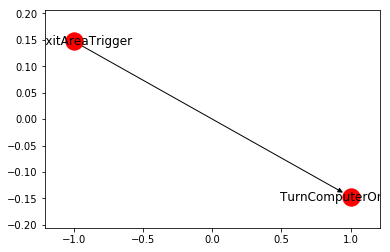

66.249.83.11 - - [13/Sep/2020 18:24:30] "POST / HTTP/1.1" 200 -


[INFO] Command added at 1599989075
{'action': 'enable', 'number': '', 'object': ['computer'], 'pos_object': 'self', 'pos_action': 'leave', 'position': ['if'], 'any': '', 'time': '', 'params': ['home']}
{'action': 'disable', 'number': '', 'object': ['light'], 'pos_object': '', 'time': '', 'params': [], 'any': '', 'pos_action': '', 'position': ['then']}


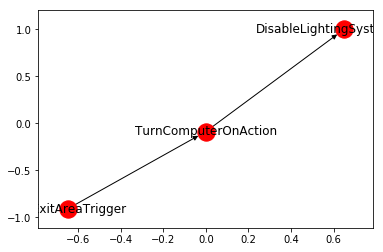

66.249.83.9 - - [13/Sep/2020 18:24:35] "POST / HTTP/1.1" 200 -


[INFO] Command undone at 1599989080
{'action': 'enable', 'number': '', 'object': ['computer'], 'pos_object': 'self', 'pos_action': 'leave', 'position': ['if'], 'any': '', 'time': '', 'params': ['home']}


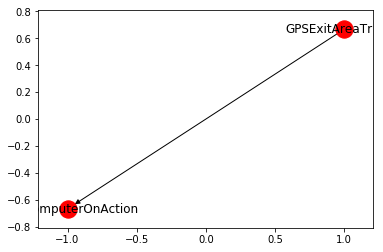

66.249.83.9 - - [13/Sep/2020 18:24:40] "POST / HTTP/1.1" 200 -


[INFO] Command added at 1599989088
{'action': 'enable', 'number': '', 'object': ['computer'], 'pos_object': 'self', 'pos_action': 'leave', 'position': ['if'], 'any': '', 'time': '', 'params': ['home']}
{'action': 'disable', 'number': '', 'object': ['light'], 'pos_object': '', 'time': '', 'params': [], 'any': '', 'pos_action': '', 'position': []}


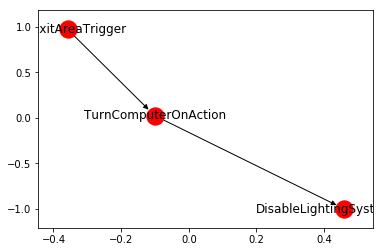

66.249.83.9 - - [13/Sep/2020 18:24:48] "POST / HTTP/1.1" 200 -


[INFO] Feedback suggested at 1599989088


66.249.83.11 - - [13/Sep/2020 18:24:54] "POST / HTTP/1.1" 200 -


[INFO] Current feedback is provided at 1599989094
{'action': 'enable', 'number': '', 'object': ['computer'], 'pos_object': 'self', 'pos_action': 'leave', 'position': ['if'], 'any': '', 'time': '', 'params': ['home']}
{'action': 'disable', 'number': '', 'object': ['light'], 'pos_object': '', 'time': '', 'params': [], 'any': '', 'pos_action': '', 'position': []}
[INFO] New mashup created at 1599989100 - [{'pos_object': 'self', 'number': '', 'object': ['computer'], 'action': 'enable', 'pos_action': 'leave', 'params': ['home'], 'any': '', 'time': '', 'position': ['if']}, {'pos_object': '', 'number': '', 'object': ['light'], 'action': 'disable', 'time': '', 'position': [], 'any': '', 'pos_action': '', 'params': []}]
{'action': 'enable', 'number': '', 'object': ['computer'], 'pos_object': 'self', 'pos_action': 'leave', 'position': ['if'], 'any': '', 'time': '', 'params': ['home']}
{'action': 'disable', 'number': '', 'object': ['light'], 'pos_object': '', 'time': '', 'params': [], 'any': '', 

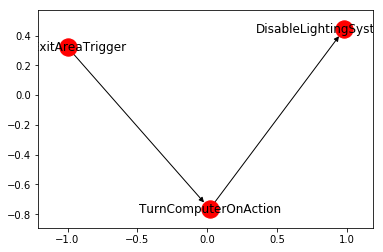

66.249.83.9 - - [13/Sep/2020 18:25:00] "POST / HTTP/1.1" 200 -


In [ ]:
if __name__ == "__main__":
    app.run(host='0.0.0.0', port=443, ssl_context=('server.crt', 'server.key'))